## Robuts Linear Regression

In [26]:
import pandas as pd 
import numpy as np
import arviz as az
import pymc as pm
import palmerpenguins as pp
import scipy.stats as stats
import matplotlib.pyplot as plt

### Not Robust Model

In [27]:
def generate_sales(*, days, mean, std, label):
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    return df

In [28]:
empanadas = generate_sales(days= 200, mean= 180, std= 30, label= "Empanadas")
empanadas.iloc[0] = [50, 92000, "Empanada"]
empanadas.iloc[1] = [60, 90000, "Empanada"]
empanadas.iloc[2] = [70, 96000, "Empanada"]
empanadas.iloc[3] = [80, 91000, "Empanada"]
empanadas.iloc[4] = [90, 99000, "Empanada"]

In [29]:
with pm.Model() as model_empandas_sales:
 sigma = pm.Normal("sigma", 50)
 beta = pm.Normal("beta", mu= 150, sigma= 20)

 mu = pm.Deterministic("mu", beta * empanadas["customers"])
 sales = pm.Normal("sales", mu= mu, sigma= sigma, observed= empanadas["sales"])

 idata = pm.sample(random_seed= 42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


In [30]:
with model_empandas_sales:
    pm.sample_posterior_predictive(idata, extend_inferencedata= True, random_seed= 42)

Sampling: [sales]


In [31]:
az.summary(idata, var_names= ["beta", "sigma"], kind= "stats").round(2)

,mean,sd,hdi_3%,hdi_97%
beta,208.18,0.44,207.34,208.96
sigma,436.08,0.53,435.00,437.01


In [32]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

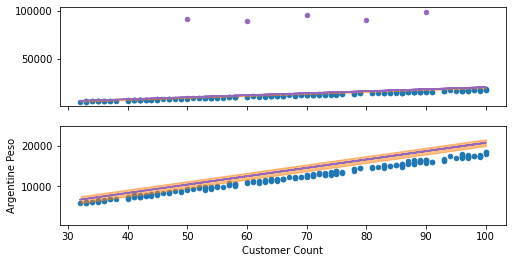

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
mu_m = idata.posterior["mu"].values.reshape(-1, empanadas.shape[0]).mean(axis=0)

for i in range(2):
    empanadas.sort_values("sales")[:-5].plot(x="customers", y="sales", kind="scatter", ax=axes[i]);
    empanadas.sort_values("sales")[-5:].plot(x="customers", y="sales", kind="scatter", c="C4", ax=axes[i]);
    axes[i].plot(empanadas.customers, mu_m, c='C4')
    az.plot_hdi(empanadas.customers, idata.posterior_predictive["sales"], hdi_prob=.95, ax=axes[i])

    axes[1].set_ylabel("Argentine Peso")

axes[0].set_ylabel("")
axes[1].set_xlabel("Customer Count")
axes[1].set_ylim(400, 25000);

### Robust Model with StudentT nu value

In [34]:
with pm.Model() as model_robust:

 sigma = pm.Normal("sigma", 50)
 beta = pm.Normal("beta", mu= 150, sigma= 20)
 nu = pm.HalfNormal("nu", 20)

 mu = pm.Deterministic("mu", beta * empanadas["customers"])

 sales = pm.StudentT("sales", mu= mu, sigma= sigma, nu= nu, observed= empanadas["sales"])

 idata_robust = pm.sample(random_seed= 42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, nu]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [35]:
with model_robust:
    pm.sample_posterior_predictive(idata_robust, extend_inferencedata= True, random_seed= 42)

Sampling: [sales]


In [36]:
az.summary(idata_robust, var_names= ["beta", "sigma", "nu"], kind= "stats").round(2)

,mean,sd,hdi_3%,hdi_97%
beta,179.46,0.18,179.14,179.82
sigma,51.22,0.96,49.30,52.90
nu,0.62,0.06,0.52,0.72


Text(0.5, 1.0, 'Empanada Sales with Robust Regression Fit')

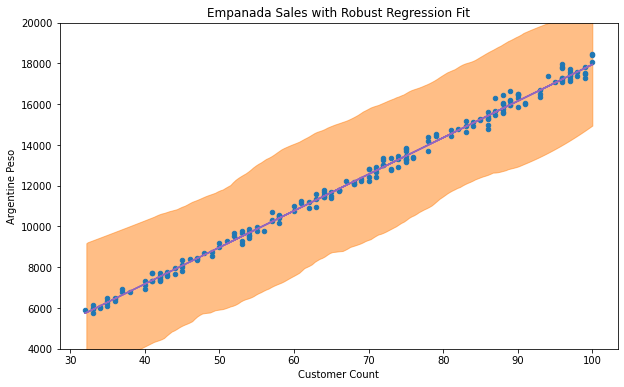

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
mu_m = idata_robust.posterior["mu"].values.reshape(-1, empanadas.shape[0]).mean(axis=0)

ax.plot(empanadas.customers, mu_m, c='C4')
az.plot_hdi(empanadas.customers, idata_robust.posterior_predictive["sales"], hdi_prob=.95, ax=ax)

empanadas.plot(x="customers", y="sales", kind="scatter", ax=ax)
ax.set_ylim(4000, 20000);
ax.set_ylabel("Argentine Peso")
ax.set_xlabel("Customer Count")
ax.set_title("Empanada Sales with Robust Regression Fit")